# Report - ProgrammingTask

#### Scope of the Project
Time series forecasting for blood glucose (BG) values provides valuable information for improving the insulin management for patients with type 1 diabetes (PwT1D). Reliable BG forecasting holds the potential to improve the automated meal announcement and possible insulin treatment (bolus dose, and basal rate) adjustments. Further, certain events could trigger alarms to inform the patient with respect to risks of potential future hypo- or hyperglycemia. However, the problem complexity, the related uncertainties, as well as the inter- and intra-patient variabilities, makes challenging the accurate prediction of future glucose concentrations. To address these challenges, we make benefit of recent advances in deep learning. 

In this report we will remake a simple LSTM model that will forecast blood gucose levels based on recorded data from 6 pariciants utlizing information such as continuous glucose monitoring (CGM), basal insulin rate, bolus injection, the self-reported time and type of a meal, plus the patient’s carbohydrate estimate for the meal. The data was released in the OhiaT1DM dataset [3]. The measurements are provided at intervals of 5 minutes.


The report will go though:
- Dataset Analysis: Exploring dataset features.
- Data Preparation and Scaling: Steps for data preprocessing and feature scaling.
- Experiment Setup: Outline of design choices and experimental setup.
- Results: Presentation of experimental findings.
- Conclusion and Comparison: Key insights and comparison with current BG prediction methods.
Future Directions: Suggestions for further research.

Relevant sections will include executable code.

First, we need to import necessary libraries:

In [41]:
from dataprepper import DataPrepper
from datahandler import CSVDataHandler
from models import MirshekarianLSTM
from trainer import Trainer
from evaluator import Evaluator

import torch
import torch.nn as nn
import torch.optim as optim

from datahandler import CSVDataHandler
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from torch.utils.data import TensorDataset, DataLoader
#Getting rid of the annoying warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Dataset
### Ohio Dataset
The dataset contains:
- Continuous glucose monitoring (CGM) data, recorded every 5 minutes, for 12 people with type 1 diabetes over 8 weeks.
- Insulin doses, both bolus and basal, delivered by insulin pumps.
- Physiological sensor data, such as heart rate, galvanic skin response, and step count, 

Data was gathered from six participants in 2018 using the Basis Peak physiological sensor. In 2020, the same data was collected from an additional six participants using the Empatica Embrace bands3 physiological sensor. In this report we will only consider the data collected in 2018.

In [42]:
#Read data
participants = [559,563,570,575,588,591]
directory_path_train = os.path.join('Ohio Data', 'Ohio2018_processed', 'train')
train_handler = CSVDataHandler(directory_path_train, 'train')
train_handler.load_csv_files()


#### Short Feature Analysis

##### Factor Distribution

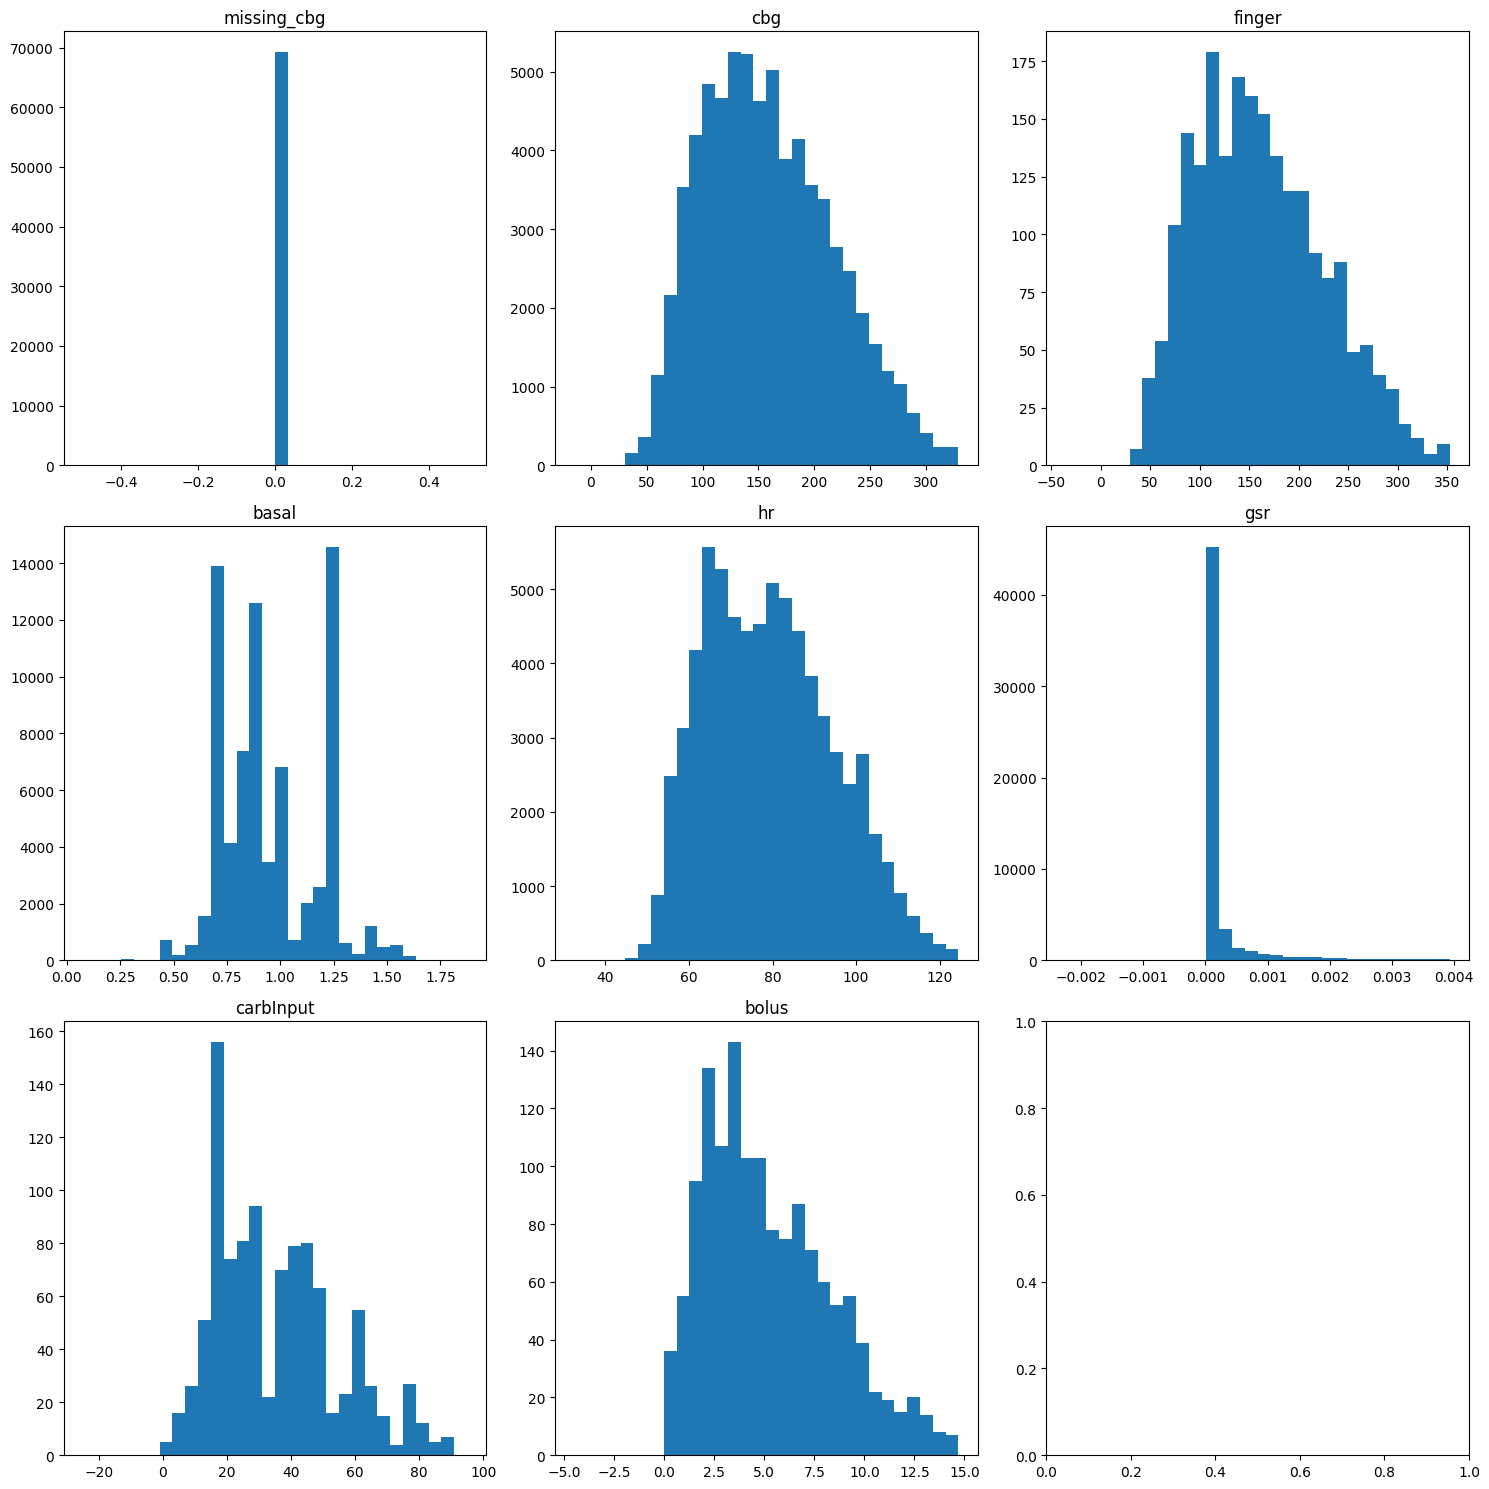

In [43]:
import math

df = train_handler.get_combined_df()
df = df.drop(columns='5minute_intervals_timestamp')
quantiles = df.quantile([0.25, 0.75])
Q1 = quantiles.loc[0.25]
Q3 = quantiles.loc[0.75]
IQR = Q3 - Q1

num_columns = 3
fig, axs = plt.subplots(math.ceil(len(df.columns) / num_columns), num_columns, figsize=(15, 15))

for i, column in enumerate(df.columns):
    axs.flat[i].hist(df[column].dropna(), range=(Q1[column] - 1.5*IQR[column], Q3[column] + 1.5*IQR[column]), bins=30)
    axs.flat[i].set_title(column)

fig.tight_layout()
plt.show()


cbg: The distribution of the CBG values is approximately bell-shaped, which is typical for biological measurements. It's somewhat right-skewed, indicating that there are some higher outliers or that the distribution is not perfectly normal. The bulk of the CBG values are distributed between approximately 50 to 250.

finger: The distribution of fingerstick blood glucose measurements appears similar to that of CBG, suggesting a rough normal distribution with a right skew. This implies that most readings are within a common range, with a few higher readings.

basal: The histogram for basal insulin shows several peaks, suggesting that there are common set values for basal insulin delivery, which may correspond to typical dosing strategies or pump settings.

hr: The heart rate (hr) histogram appears to be roughly normally distributed, centered around a value that could be around 70-80 bpm, which is common for resting heart rates in adults.

carbInput: The carbohydrate input histogram shows a right-skewed distribution with most values concentrated near 0, indicating many instances with no or low carbohydrate intake, and fewer instances with higher carbohydrate intake.

bolus: This histogram is also right-skewed, similar to carbInput, indicating that most of the bolus insulin doses are on the lower end, with a few larger doses.

#### Correlation Matrix

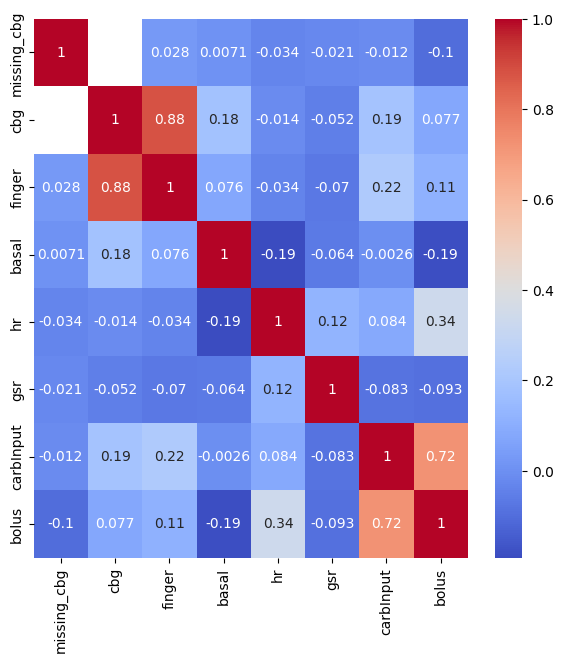

In [44]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the heatmap of the correlation matrix
plt.figure(figsize=(7,7))  # Adjust the size of the figure
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

finger: The correlation coefficient is 0.88, indicating a very strong positive correlation with cbg. This is expected since both are measurements of blood glucose levels, although possibly measured at different times or under different conditions.

basal: The correlation coefficient is 0.18, which is a low positive correlation. It suggests a slight linear relationship where higher basal insulin could be associated with higher cbg readings, but this relationship is not very strong.

carbInput: The correlation coefficient is 0.22, also indicating a low positive correlation. This suggests that there is a slight linear relationship where higher carbohydrate intake might be associated with higher cbg readings.

bolus: The correlation coefficient is 0.11, which is a very low positive correlation. This indicates that there is a minimal linear relationship between bolus insulin dosages and cbg readings.

The other features (missing_cbg, hr, and gsr) have even lower correlation coefficients with cbg, indicating very weak to no linear relationships.

When building a predictive model for cbg, you might prioritize finger as a feature due to its high correlation. However, given that finger is likely another blood glucose measurement, it may not be a separate predictive feature but rather an alternative measurement of the same outcome you're trying to predict.

Basal and carbInput could be considered as well, but it's important to remember that correlation does not imply causation, and the actual predictive power of these features needs to be evaluated within the context of a model. Features with lower correlation coefficients might still provide valuable information when combined with other features, especially if they capture different aspects of the underlying physiological processes.

Finally, always consider the domain-specific knowledge: for instance, in diabetes management, both carbohydrate intake and insulin dosages are key factors that influence blood glucose levels, and they might have complex nonlinear relationships with cbg that aren't fully captured by a correlation coefficient. Thus, they are typically included in predictive modeling for blood glucose levels despite low to moderate correlation coefficients.

## Data Preparation

### Feature Selection

Based on both the review paper and the feature analysis above

In [45]:
features = ['cbg', 'basal', 'carbInput', 'bolus']

### Preprocessing

Using cubic spline for the cbg value
Weird that they used cubic spline for all the features in the survey paper. Here set to 0

In [46]:
fill_types = ['cubicspline', 0, 0, 0]
train_handler.handle_missing_values(features, fill_types)

### Feature scaling

Yes, using StandardScaler from scikit-learn to scale features is a common preprocessing step before training machine learning models, especially when using algorithms that are sensitive to the scale of the data, such as:

Support Vector Machines (SVMs)
k-Nearest Neighbors (k-NN)
Principal Component Analysis (PCA)
Gradient Descent-based algorithms (like neural networks)
The StandardScaler standardizes features by removing the mean and scaling to unit variance, bringing all of them to the same scale without distorting differences in the range of values. This can be particularly helpful for optimizing algorithms and can also help with the interpretability of models by giving you standardized coefficients.

For each feature, the StandardScaler computes the following:

$$ z = \frac{(x - \mu)}{\sigma} $$

where:
- $x$ is the original feature value,
- $\mu$ is the mean of the feature values,
- $\sigma$ is the standard deviation of the feature values,
- $z$ is the standardized value.

Here are some considerations when using StandardScaler:

Normalization: If your features have different units or scales, normalization can help your model to converge faster and prevent the model from prioritizing certain features over others due to the scale.

Distribution: While StandardScaler is robust and commonly used, it assumes that the data for each feature is normally distributed. If a feature has a highly skewed distribution, you might need to transform it first (e.g., using a logarithmic transformation) to approximate a normal distribution before scaling.

Outliers: StandardScaler is sensitive to outliers. If your data contains many outliers, scaling can be influenced by them. In such cases, you might consider using RobustScaler, which is less sensitive to outliers.

Interpretability: Scaling changes the actual values of features, which can impact the interpretability of certain models. For example, in a linear regression model, the coefficients can no longer be interpreted as the change in the outcome variable for a one-unit change in the predictor variable.

Inverse Transformation: After making predictions with a model trained on scaled data, you may want to transform the predictions back to the original scale for interpretation or reporting. StandardScaler provides an inverse_transform method for this purpose.

Before applying StandardScaler, it's important to fit it only on the training data and then use the same parameters (mean and standard deviation) to transform both the training and the test data. This prevents information from the test set leaking into the model training process, preserving the validity of your evaluation metrics.

In [47]:
import joblib
scaler = StandardScaler()
scaler.fit(train_handler.get_combined_df()[features])
#Save scaler for later use
joblib.dump(scaler, "scalers"+os.sep+'scaler_2018.pkl')

['scalers\\scaler_2018.pkl']

## Experiments

### Design choices

Numbers of steps to forecast:

In [48]:
forecast_steps = 6

As all models will be trained in the same manner

In [49]:
def train_model_for_programming_task(participants, scaler, model_path='best_model.pth', forecast_steps=6, pretrained_model_path=None):
    features = ['cbg', 'basal', 'carbInput', 'bolus']
    fill_types = ['cubicspline', 0, 0, 0]

    directory_path_train = os.path.join('Ohio Data', 'Ohio2018_processed', 'train')
    train_handler = CSVDataHandler(directory_path_train, 'train')
    train_handler.load_csv_files()
    train_handler.handle_missing_values(features, fill_types)

    directory_path_test = os.path.join('Ohio Data', 'Ohio2018_processed', 'test')
    test_handler = CSVDataHandler(directory_path_test, 'test')
    test_handler.load_csv_files()
    test_handler.handle_missing_values(features, fill_types)


    #initialize data prepper and make features and target pair
    prepper = DataPrepper(participants, train_handler, forecast_steps=forecast_steps, scaler=scaler)
    features_train, target_train = prepper.make_features_and_targetpair()

    # Create TensorDatasets
    ########################
    # Split the training data into training and validation sets
    features_train, features_val, target_train, target_val = train_test_split(
        features_train, target_train, test_size=0.2, random_state=42)

    # Create TensorDatasets for the training and validation sets
    train_data = TensorDataset(features_train, target_train)
    val_data = TensorDataset(features_val, target_val)

    # Create DataLoaders
    batch_size = 32
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)
    ########################

    model = MirshekarianLSTM(input_dim=4, hidden_dim=5, output_dim=1)
    #initialize model
    if pretrained_model_path != None:
        pretrained_model_dir = os.path.dirname(pretrained_model_path)
        if not os.path.exists(pretrained_model_dir):
            os.makedirs(pretrained_model_dir)
        model.load_state_dict(torch.load(pretrained_model_path))


    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Train the model
    trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, model_path=model_path)

    trainer.train()

#train_model_for_programming_task([559,563,570,575,588,591])


### Forcasting models

#### Inter-patient Model
Creating an inter-patient model, which means a model that is trained on data from multiple patients and is intended to be generalizable across new patients, has several potential benefits in the context of healthcare and medical predictions:

Generalizability: An inter-patient model is designed to work across a diverse patient population. It aims to capture the underlying patterns that are common across different individuals, leading to a model that is more likely to perform well on new patients who were not part of the training data.

Scalability: Once developed, an inter-patient model can be deployed at scale without the need for individualized training, making it more practical and cost-effective for widespread use in clinical settings.

Data Efficiency: By leveraging data from multiple patients, these models can learn from a much larger and more varied dataset than single-patient models. This can be especially valuable in cases where data from individual patients is limited.

Robustness: Models trained on a diverse set of patient data are more likely to be robust to variations in data that can occur due to differences in demographics, disease progression, treatment responses, and measurement devices.

Insights into Disease: Inter-patient models can provide insights into commonalities in disease patterns and treatment responses across patients, which can be valuable for medical research and understanding disease mechanisms.

Resource Optimization: In situations where personalized models are not feasible due to resource constraints, an inter-patient model can provide a viable solution that still offers benefits over a one-size-fits-all approach.

Benchmarking: Inter-patient models can serve as benchmarks for assessing the performance of personalized models. If a personalized model does not significantly outperform an inter-patient model, it may not be worth the additional complexity and cost.

Regulatory Approval: It might be easier to obtain regulatory approval for a model that has been validated across a broad patient population, as it demonstrates the model's safety and efficacy across diverse groups.

However, there are also challenges associated with inter-patient models, such as the need to handle inter-patient variability and the risk of models being biased towards patient subgroups that are overrepresented in the training data. Careful design, validation, and testing are required to ensure that inter-patient models are both effective and equitable.

In [ ]:
# Train one model from all data from all participants except test participant

for participant in participants:
    train_participants = [p for p in participants if p != participant]
    model_path = os.path.join('models', 'inter-patient', str(forecast_steps), f'best_model_{participant}.pth')
    train_model_for_programming_task(train_participants, scaler, model_path, forecast_steps)

#### Intra-patient Model
An intra-patient model, in contrast to an inter-patient model, is designed and trained using data from a single patient. This type of model is tailored to the individual characteristics and data patterns specific to that patient. Here are some benefits of using an intra-patient model:

Personalization: An intra-patient model can be highly personalized, accounting for the unique physiological responses and patterns of the individual, potentially leading to more accurate predictions or treatment recommendations for that specific patient.

High Sensitivity: Because the model is trained on data from a single patient, it can become highly sensitive to the subtle changes and trends within that patient’s data, which might be overlooked in models trained on data from multiple patients.

Overfitting Reduction: With intra-patient models, the risk of overfitting to a particular patient's data is not necessarily a downside, as the model is intended to be patient-specific. This can sometimes allow for a more complex model that captures the nuances of an individual’s health data.

Customized Treatment: For chronic conditions that require ongoing management and treatment adjustments, such as diabetes or hypertension, intra-patient models can help tailor treatment plans to the individual’s changing needs.

Rare Conditions: In cases where a patient has a rare condition and there may not be a large dataset of similar patients to learn from, an intra-patient model can leverage all available information from that one patient to provide the best possible care.

Patient Engagement: These models can be used to engage patients in their own care by providing insights and predictions that are highly relevant to them, potentially increasing adherence to treatment plans.

Rapid Adaptation: An intra-patient model can quickly adapt to new data from the patient, making it well-suited for conditions where the patient’s state can change rapidly.

Privacy: Since the data does not need to be pooled with other patients' data, there may be fewer concerns about privacy and data sharing, which can be particularly sensitive in healthcare.

Despite these benefits, intra-patient models also come with challenges:

Data Scarcity: A single patient may not generate enough data to train a robust model, leading to issues with underfitting or poor generalization to new states or conditions not present in the training data.

Lack of Generalizability: These models are not intended to be applied to other patients, which limits their broader applicability.

Maintenance and Update: Personalized models require regular updates as new data becomes available or the patient’s condition changes, which can be resource-intensive.

Variability: There may be more variability in a single patient’s data due to factors like measurement errors, lifestyle changes, or unrecorded interventions, which can affect the model’s performance.

In practice, whether to use an intra- or inter-patient model often depends on the specific healthcare application, the availability and type of data, and the intended use case. Both approaches have their place in personalized medicine, with intra-patient models offering customization at the individual level and inter-patient models providing broader insights applicable across patient populations.

In [ ]:
# Train one model per participant from only data from that participant

for participant in participants:
    train_participants = [participant]
    model_path = os.path.join('models', 'intra-patient', str(forecast_steps), f'best_model_{participant}.pth')
    train_model_for_programming_task(train_participants, scaler, model_path, forecast_steps)

#### Inter- and intra-patient Model
Creating a model that integrates both intra-patient and inter-patient data can be highly beneficial, as it attempts to leverage the strengths of both approaches. This hybrid model can be designed to generalize across a population while also adapting to individual-specific data. Here are some potential benefits:

Balanced Personalization and Generalization: Such a model can learn general patterns from a larger population and fine-tune predictions for individual patients using their specific data.

Improved Robustness: By training on diverse data from multiple patients, the model can learn to be robust to a variety of conditions and may improve its predictive accuracy for any single patient by understanding broader patterns.

Transfer Learning: This approach is akin to transfer learning, where a model pre-trained on a large dataset (inter-patient data) is fine-tuned on a smaller, specific dataset (intra-patient data). It can be particularly effective when data for some patients is limited.

Handling Data Sparsity: For patients with limited historical data, the inter-patient component can provide a solid foundation, and as more personal data becomes available, the intra-patient component can start to play a larger role.

Enhanced Predictive Performance: The combination of both data types can enhance the predictive performance by capturing both the population-level trends and individual variations.

Flexibility: Such a model can still be useful even if individual data for certain patients is not available, as it can rely on the inter-patient component in those cases.

However, there are also challenges associated with creating a hybrid model:

Model Complexity: The model may become more complex as it tries to capture both individual variability and common patterns across patients.

Risk of Overfitting: There is a risk that the model overfits the individual patient data and loses its ability to generalize to other patients.

Data Integration: Careful thought must be given to how individual patient data is integrated with the broader dataset, especially if there are significant differences in the number of data points or the types of data available for different patients.

Computational Resources: Training a hybrid model can be computationally intensive, as it may require processing large datasets and possibly implementing more sophisticated model architectures.

In conclusion, a model that combines both intra-patient and inter-patient data can be powerful, but it needs to be designed and validated carefully to ensure it achieves the intended balance between personalization and generalization.

In [ ]:
for participant in participants:
    train_participants = participants
    model_path = os.path.join('models', 'inter_and_intra-patient', str(forecast_steps), f'best_model_{participant}.pth')
    train_model_for_programming_task(train_participants, scaler, model_path, forecast_steps)

#### Inter- and intra-patient Model - Transfer Learning
Creating a model that integrates both intra-patient and inter-patient data can be highly beneficial, as it attempts to leverage the strengths of both approaches. This hybrid model can be designed to generalize across a population while also adapting to individual-specific data. Here are some potential benefits:

Balanced Personalization and Generalization: Such a model can learn general patterns from a larger population and fine-tune predictions for individual patients using their specific data.

Improved Robustness: By training on diverse data from multiple patients, the model can learn to be robust to a variety of conditions and may improve its predictive accuracy for any single patient by understanding broader patterns.

Transfer Learning: This approach is akin to transfer learning, where a model pre-trained on a large dataset (inter-patient data) is fine-tuned on a smaller, specific dataset (intra-patient data). It can be particularly effective when data for some patients is limited.

Handling Data Sparsity: For patients with limited historical data, the inter-patient component can provide a solid foundation, and as more personal data becomes available, the intra-patient component can start to play a larger role.

Enhanced Predictive Performance: The combination of both data types can enhance the predictive performance by capturing both the population-level trends and individual variations.

Flexibility: Such a model can still be useful even if individual data for certain patients is not available, as it can rely on the inter-patient component in those cases.

However, there are also challenges associated with creating a hybrid model:

Model Complexity: The model may become more complex as it tries to capture both individual variability and common patterns across patients.

Risk of Overfitting: There is a risk that the model overfits the individual patient data and loses its ability to generalize to other patients.

Data Integration: Careful thought must be given to how individual patient data is integrated with the broader dataset, especially if there are significant differences in the number of data points or the types of data available for different patients.

Computational Resources: Training a hybrid model can be computationally intensive, as it may require processing large datasets and possibly implementing more sophisticated model architectures.

In conclusion, a model that combines both intra-patient and inter-patient data can be powerful, but it needs to be designed and validated carefully to ensure it achieves the intended balance between personalization and generalization.

In [ ]:
# First pretrained on data from all patients. Then trained on data for the specific patient

for participant in participants:
    train_participants = [participant]
    pretrained_model_path = os.path.join('models', 'inter-patient', str(forecast_steps), f'best_model_{participant}.pth')
    model_path = os.path.join('models', 'inter_and_intra-patient_trans', str(forecast_steps), f'best_model_{participant}.pth')
    train_model_for_programming_task(train_participants, scaler, model_path, forecast_steps, pretrained_model_path)

## Results

Need to give some explenations on what the results will show and why I chose to use RMSE as metric 

Code for evaluating the models:

Root Mean Square Error (RMSE): 19.5083
Root Mean Square Error (RMSE): 18.9436
Root Mean Square Error (RMSE): 17.0822
Root Mean Square Error (RMSE): 23.5006
Root Mean Square Error (RMSE): 19.0771
Root Mean Square Error (RMSE): 22.0572


,Participant,RMSE
0,559,19.508343
1,563,18.943649
2,570,17.082176
3,575,23.500631
4,588,19.077105
5,591,22.057207


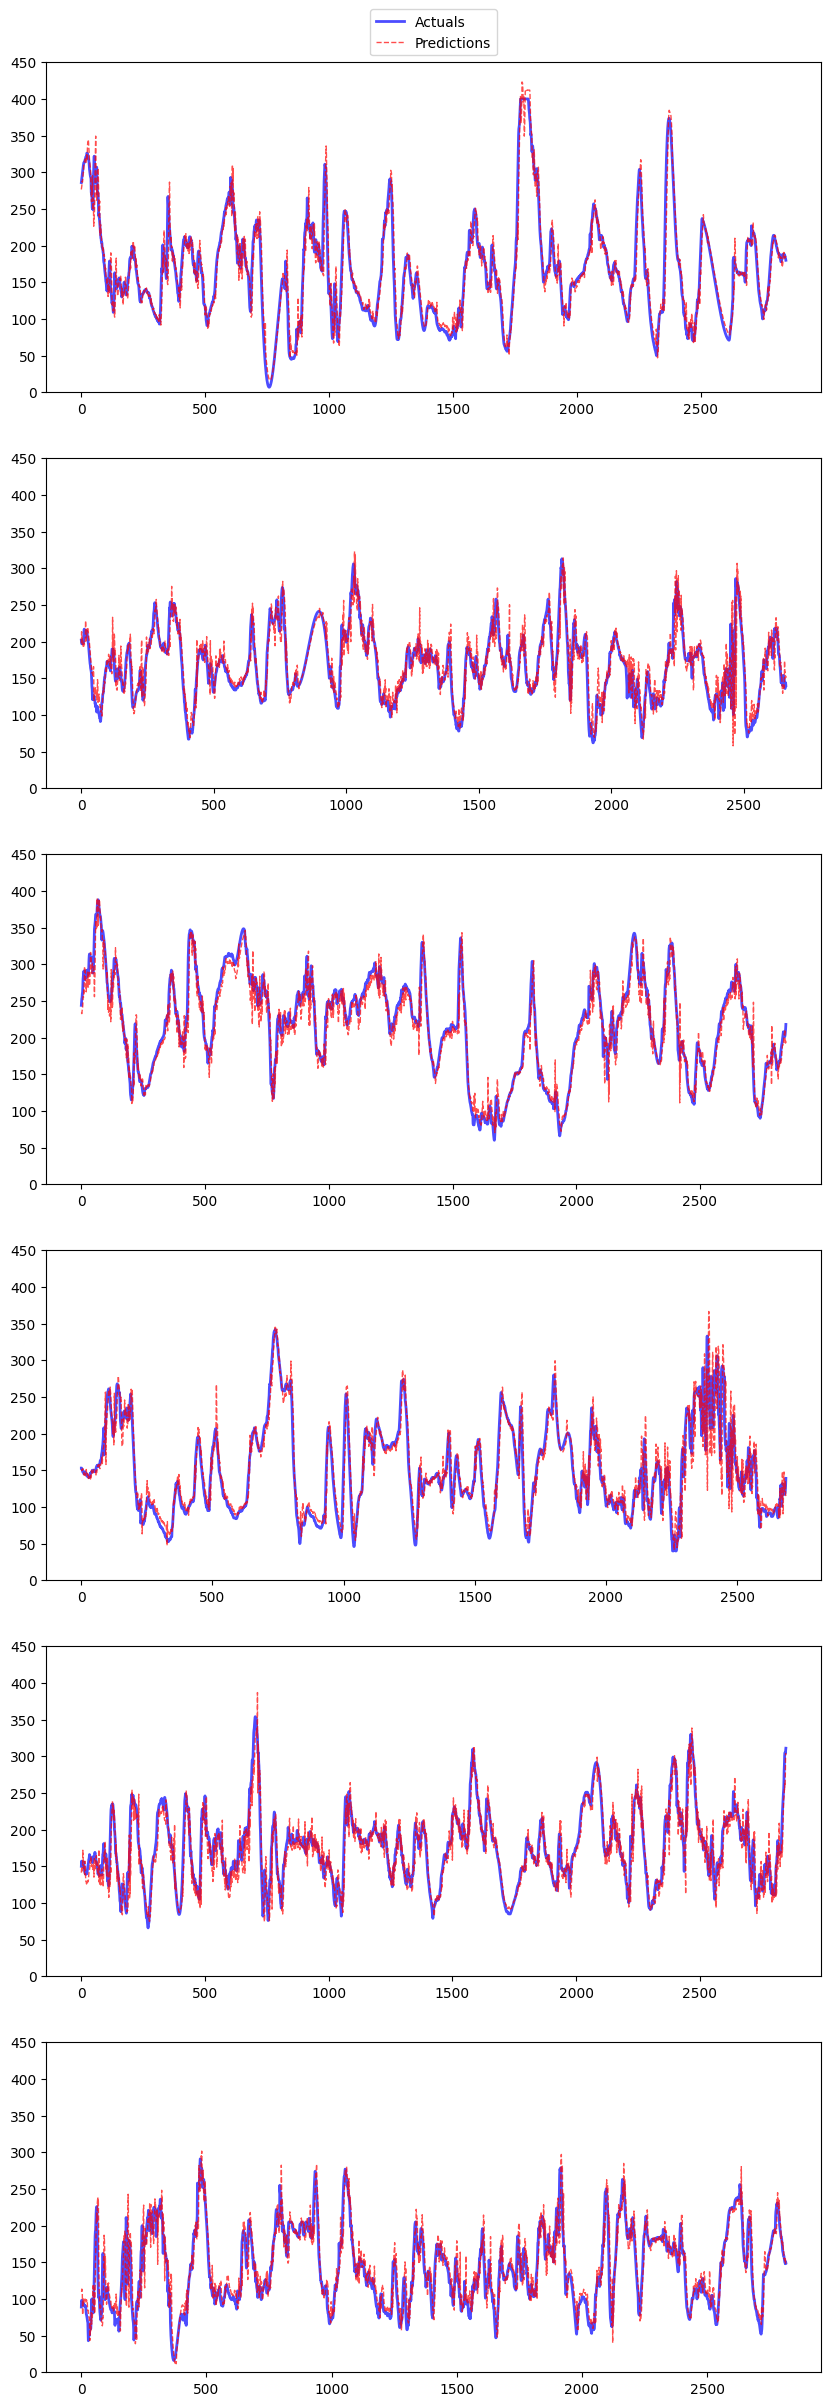

In [57]:
participants = [559,563,570,575,588,591]
plot_data = []
rmses = []
for participant in participants:
    test_participants = [participant]
    model_path = os.path.join('models', 'inter-patient', str(forecast_steps), f'best_model_{participant}.pth')
    predictions, actuals, rmse = evaluate_model_for_programming_task(test_participants, scaler, model_path, forecast_steps)
    plot_data.append((predictions, actuals))
    rmses.append(rmse)

rmse_df_inter = pd.DataFrame({'Participant': participants, 'RMSE': rmses})
display(rmse_df_inter)

fig, axs = plt.subplots(len(participants), 1, figsize=(10, 5 * len(participants)))
for i, (ax, data) in enumerate(zip(axs, plot_data)):
    predictions, actuals = data
    ax.plot(actuals, linestyle='-', linewidth=2, color='blue', alpha=0.7)
    ax.plot(predictions, linestyle='--', linewidth=1, color='red', alpha=0.7)
    if i == 0:
        ax.legend(['Actuals', 'Predictions'], loc='lower center', bbox_to_anchor=(0.5, 1.0))
    ax.set_ylim([0, 450])
plt.show()

#### Intra-patient Model

Root Mean Square Error (RMSE): 18.6002
Root Mean Square Error (RMSE): 18.9203
Root Mean Square Error (RMSE): 16.4436
Root Mean Square Error (RMSE): 23.5941
Root Mean Square Error (RMSE): 37.6024
Root Mean Square Error (RMSE): 21.9361


,Participant,RMSE
0,559,18.600180
1,563,18.920319
2,570,16.443562
3,575,23.594065
4,588,37.602425
5,591,21.936132


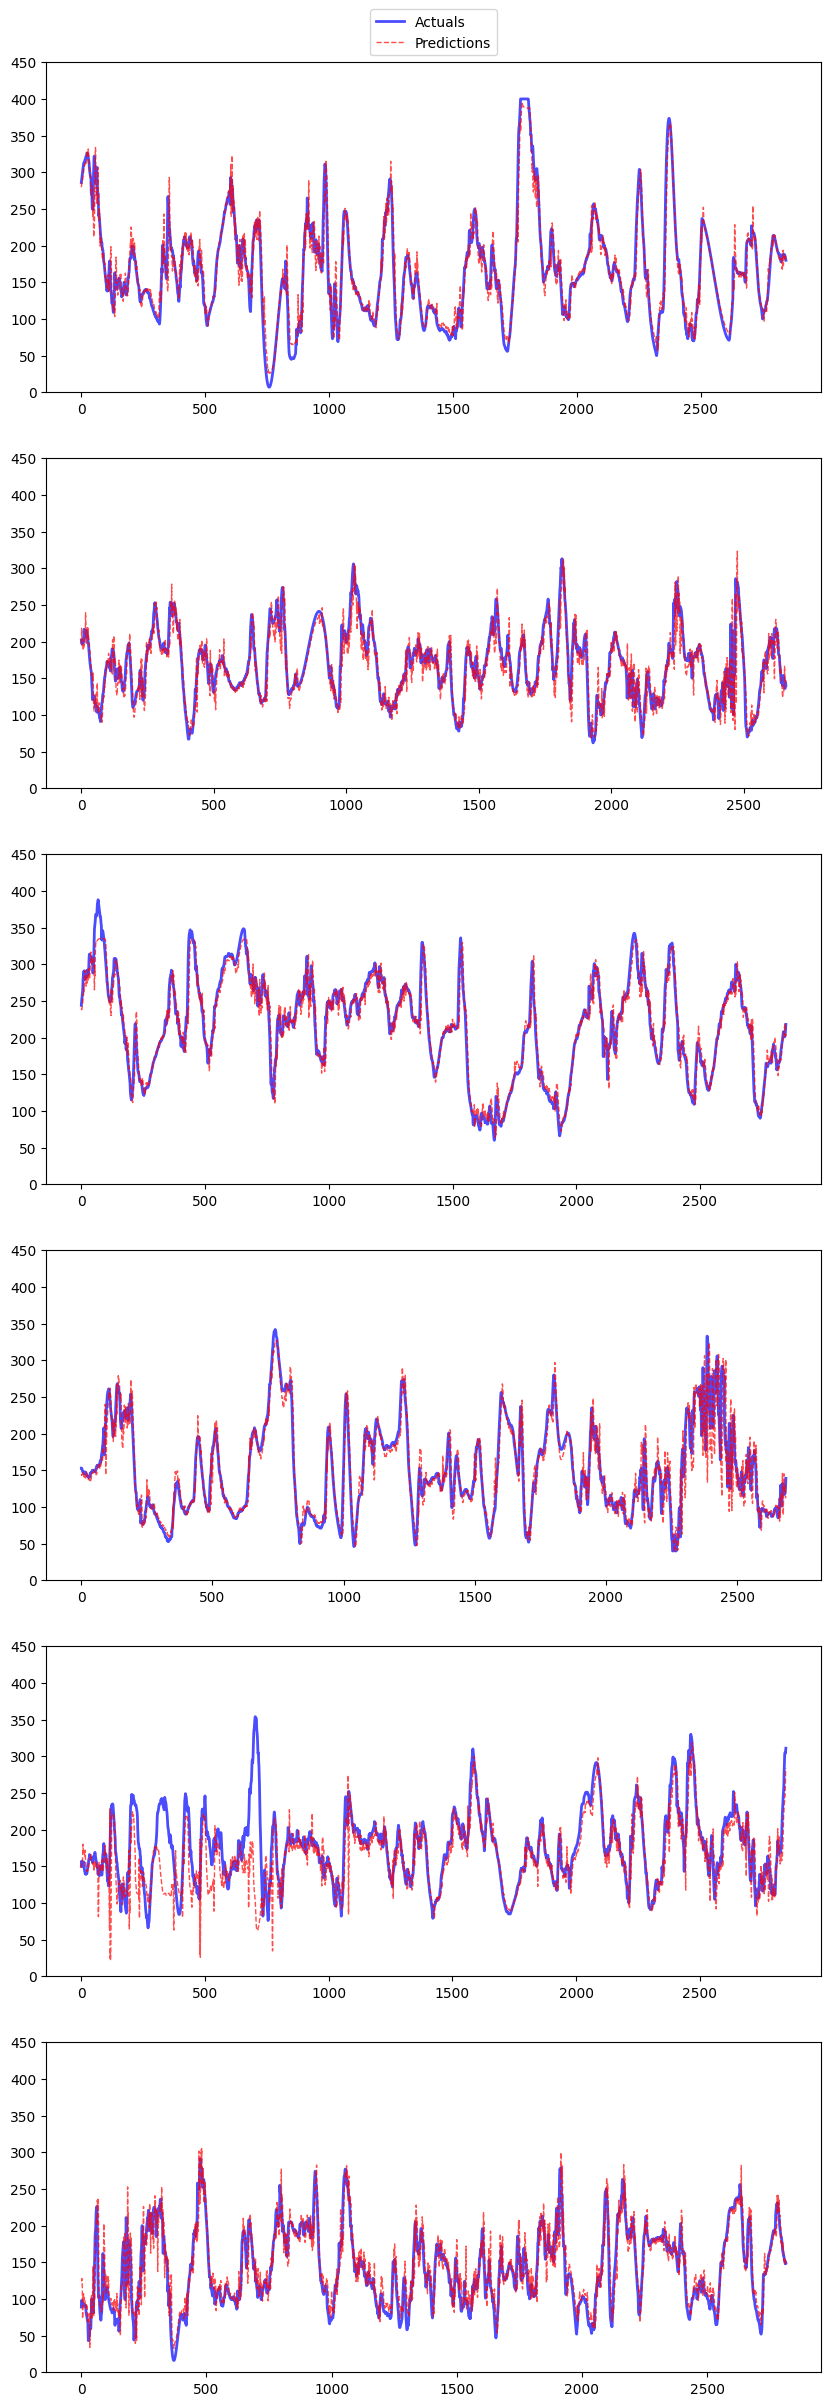

In [58]:
participants = [559,563,570,575,588,591]
plot_data = []
rmses = []
for participant in participants:
    test_participants = [participant]
    model_path = os.path.join('models', 'intra-patient', str(forecast_steps), f'best_model_{participant}.pth')
    predictions, actuals, rmse = evaluate_model_for_programming_task(test_participants, scaler, model_path, forecast_steps)
    plot_data.append((predictions, actuals))
    rmses.append(rmse)

rmse_df_intra = pd.DataFrame({'Participant': participants, 'RMSE': rmses})
display(rmse_df_intra)

fig, axs = plt.subplots(len(participants), 1, figsize=(10, 5 * len(participants)))
for i, (ax, data) in enumerate(zip(axs, plot_data)):
    predictions, actuals = data
    ax.plot(actuals, linestyle='-', linewidth=2, color='blue', alpha=0.7)
    ax.plot(predictions, linestyle='--', linewidth=1, color='red', alpha=0.7)
    if i == 0:
        ax.legend(['Actuals', 'Predictions'], loc='lower center', bbox_to_anchor=(0.5, 1.0))
    ax.set_ylim([0, 450])
plt.show()

#### Inter- and intra-patient Model


Root Mean Square Error (RMSE): 19.3572
Root Mean Square Error (RMSE): 18.4076
Root Mean Square Error (RMSE): 15.7626
Root Mean Square Error (RMSE): 23.7279
Root Mean Square Error (RMSE): 18.3533
Root Mean Square Error (RMSE): 22.0563


,Participant,RMSE
0,559,19.357210
1,563,18.407648
2,570,15.762588
3,575,23.727884
4,588,18.353296
5,591,22.056284


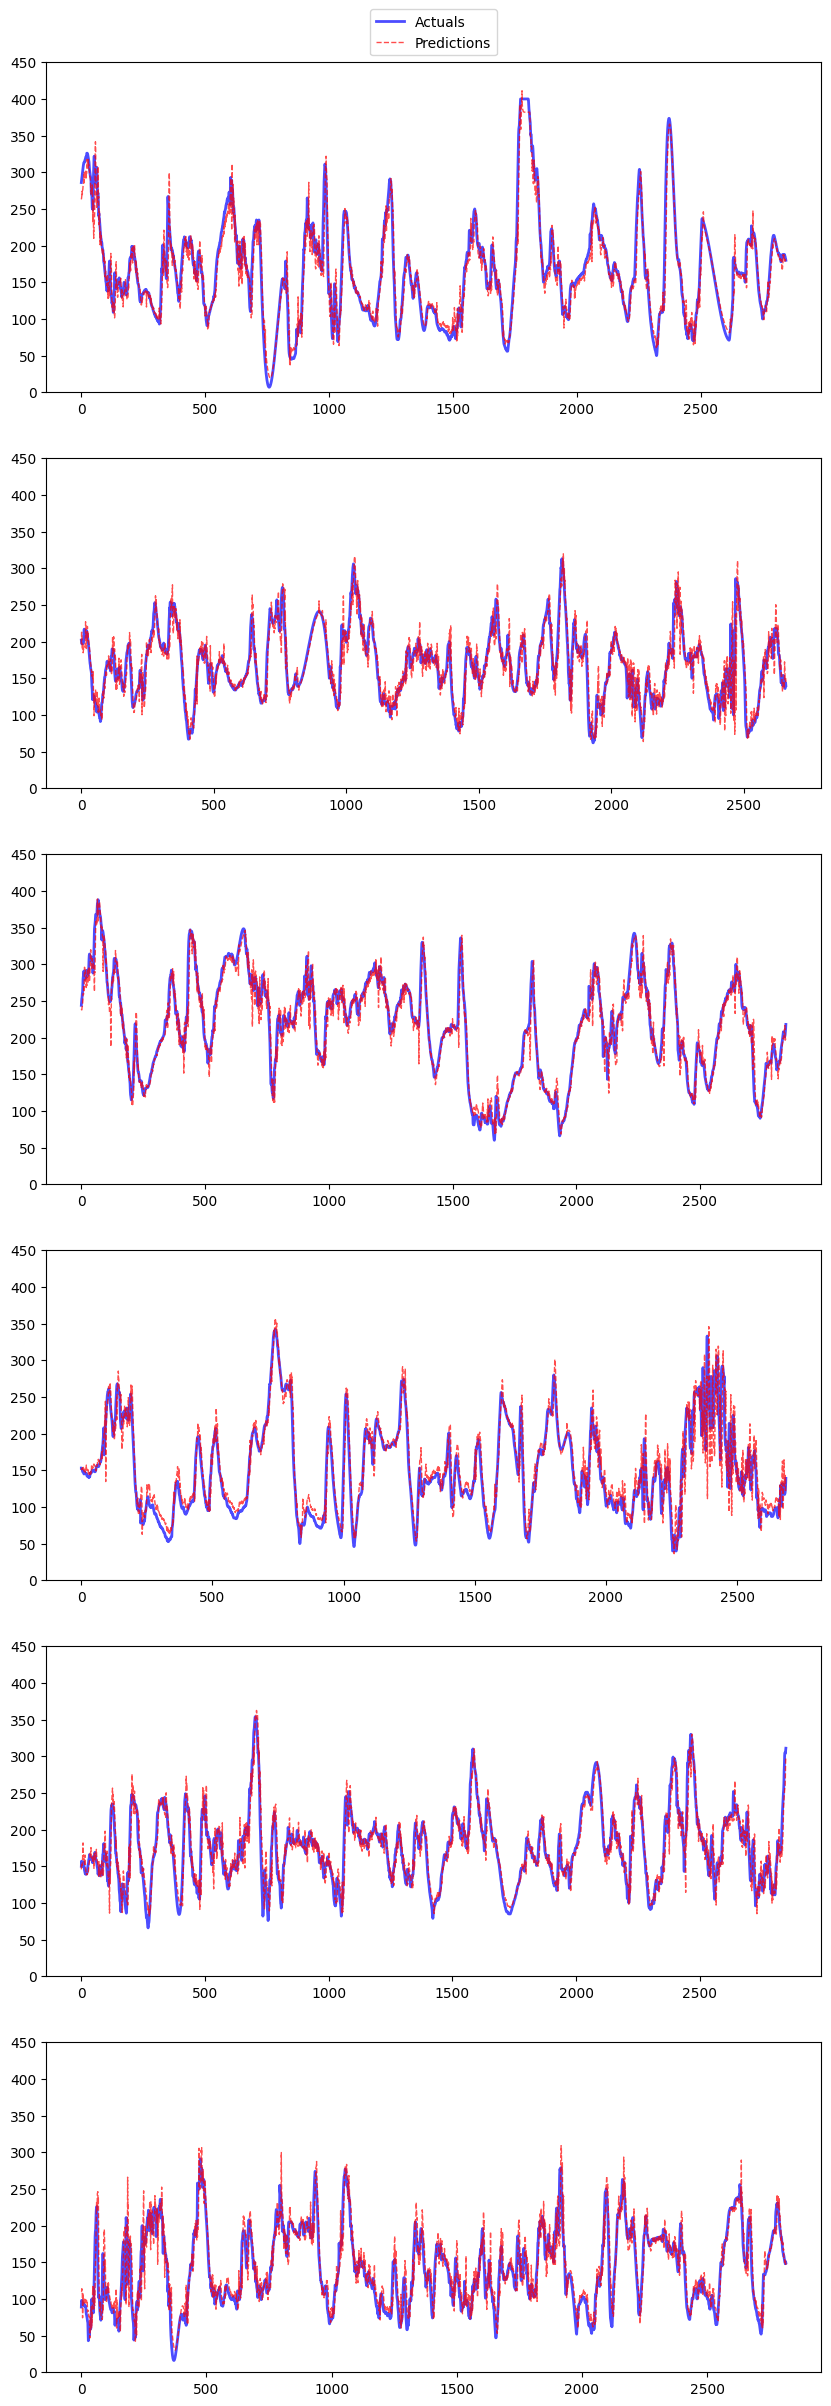

In [59]:
participants = [559,563,570,575,588,591]
plot_data = []
rmses = []
for participant in participants:
    test_participants = [participant]
    model_path = os.path.join('models', 'inter_and_intra-patient', str(forecast_steps), f'best_model_{participant}.pth')
    predictions, actuals, rmse = evaluate_model_for_programming_task(test_participants, scaler, model_path, forecast_steps)
    plot_data.append((predictions, actuals))
    rmses.append(rmse)

rmse_df_inter_and_intra_patient = pd.DataFrame({'Participant': participants, 'RMSE': rmses})
display(rmse_df_inter_and_intra_patient)

fig, axs = plt.subplots(len(participants), 1, figsize=(10, 5 * len(participants)))
for i, (ax, data) in enumerate(zip(axs, plot_data)):
    predictions, actuals = data
    ax.plot(actuals, linestyle='-', linewidth=2, color='blue', alpha=0.7)
    ax.plot(predictions, linestyle='--', linewidth=1, color='red', alpha=0.7)
    if i == 0:
        ax.legend(['Actuals', 'Predictions'], loc='lower center', bbox_to_anchor=(0.5, 1.0))
    ax.set_ylim([0, 450])
plt.show()

#### Inter- and intra-patient Model - Transfer Learning 

Root Mean Square Error (RMSE): 18.8336
Root Mean Square Error (RMSE): 18.0924
Root Mean Square Error (RMSE): 16.0221
Root Mean Square Error (RMSE): 23.6161
Root Mean Square Error (RMSE): 31.1259
Root Mean Square Error (RMSE): 22.1119


,Participant,RMSE
0,559,18.833616
1,563,18.092411
2,570,16.022125
3,575,23.616079
4,588,31.125917
5,591,22.111900


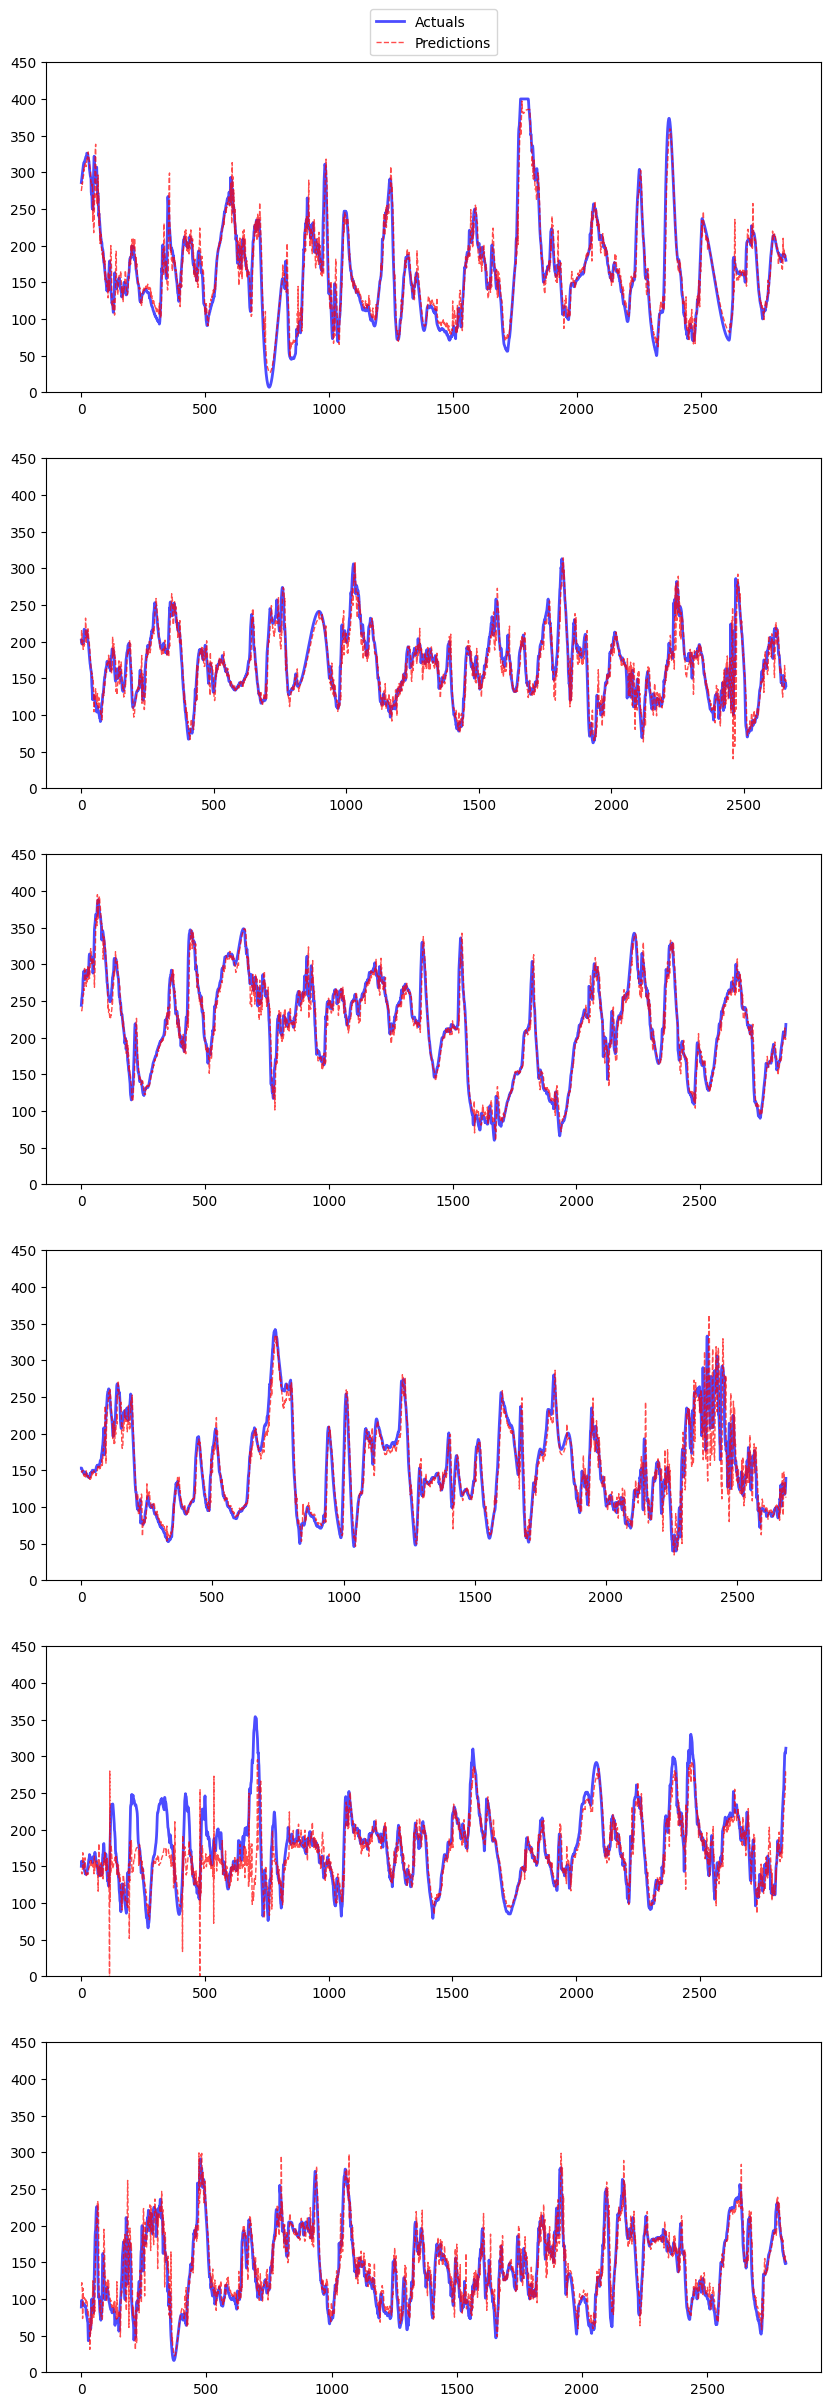

In [60]:
participants = [559,563,570,575,588,591]
plot_data = []
rmses = []
for participant in participants:
    test_participants = [participant]
    model_path = os.path.join('models', 'inter_and_intra-patient_trans', str(forecast_steps), f'best_model_{participant}.pth')
    predictions, actuals, rmse = evaluate_model_for_programming_task(test_participants, scaler, model_path, forecast_steps)
    plot_data.append((predictions, actuals))
    rmses.append(rmse)

rmse_df_inter_and_intra_patient_trans = pd.DataFrame({'Participant': participants, 'RMSE': rmses})
display(rmse_df_inter_and_intra_patient_trans)

fig, axs = plt.subplots(len(participants), 1, figsize=(10, 5 * len(participants)))
for i, (ax, data) in enumerate(zip(axs, plot_data)):
    predictions, actuals = data
    ax.plot(actuals, linestyle='-', linewidth=2, color='blue', alpha=0.7)
    ax.plot(predictions, linestyle='--', linewidth=1, color='red', alpha=0.7)
    if i == 0:
        ax.legend(['Actuals', 'Predictions'], loc='lower center', bbox_to_anchor=(0.5, 1.0))
    ax.set_ylim([0, 450])
plt.show()

,Model,RMSE
2,Inter-patient,20.028185
3,Intra-patient,22.849447
0,Inter- and intra-patient,19.610818
1,Inter- and intra-patient (Transfer Learning),21.633675


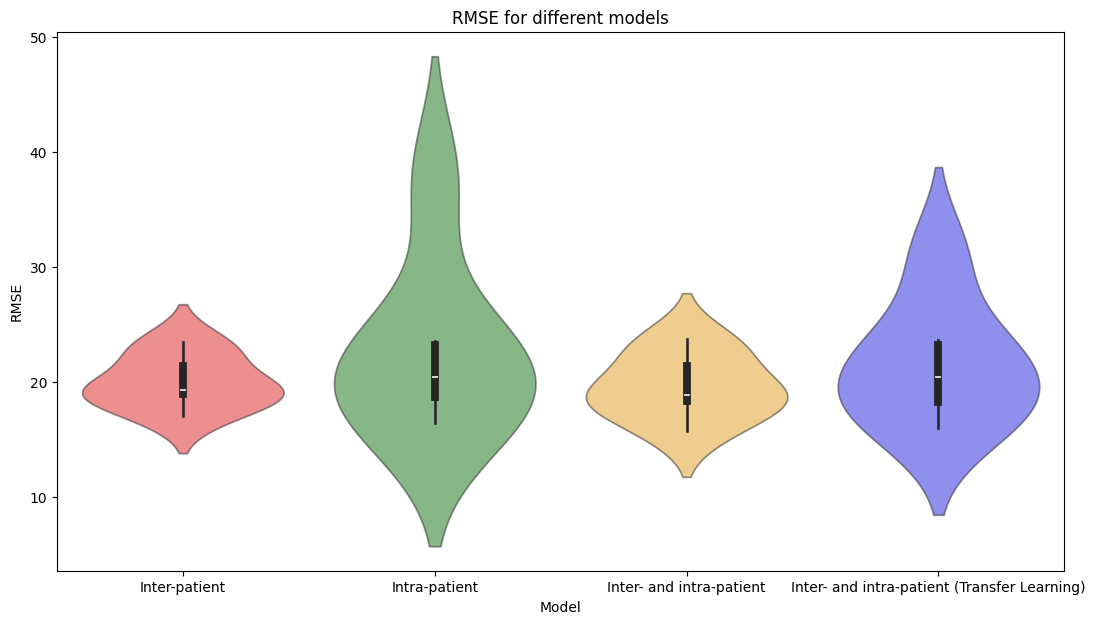

In [72]:
# Concatenate the dataframes
rmse_df = pd.concat([rmse_df_inter.assign(Model='Inter-patient'),
                     rmse_df_intra.assign(Model='Intra-patient'),
                     rmse_df_inter_and_intra_patient.assign(Model='Inter- and intra-patient'),
                     rmse_df_inter_and_intra_patient_trans.assign(Model='Inter- and intra-patient (Transfer Learning)')])

# Define a color palette
colors = {'Inter-patient': 'red', 'Intra-patient': 'green', 'Inter- and intra-patient': 'orange', 'Inter- and intra-patient (Transfer Learning)': 'blue'}

# Calculate the average RMSE per model
avg_rmse_df = rmse_df.groupby('Model')['RMSE'].mean().reset_index()
model_order = ['Inter-patient', 'Intra-patient', 'Inter- and intra-patient', 'Inter- and intra-patient (Transfer Learning)']
avg_rmse_df['Model'] = pd.Categorical(avg_rmse_df['Model'], categories=model_order, ordered=True)
avg_rmse_df = avg_rmse_df.sort_values('Model')
display(avg_rmse_df)

# Plot the violin plot
plt.figure(figsize=(13, 7))
sns.violinplot(x='Model', y='RMSE', data=rmse_df, palette=colors, alpha=0.5)
plt.title('RMSE for different models')
plt.show()


## Conclusion

## Future Work


## References
[1]	Tena, Felix, et al. "A Critical Review of the state-of-the-art on Deep Neural Networks for Blood Glucose Prediction in Patients with Diabetes." arXiv preprint arXiv:2109.02178 (2021).

[2]	Cui, Ran, et al. "Personalised short-term glucose prediction via recurrent self-attention network." 2021 IEEE 34th International Symposium on Computer-Based Medical Systems (CBMS). IEEE, 2021.

[3] Cindy Marling and Razvan Bunescu. The ohiot1dm dataset for blood glucose level prediction: Update 2020. 2020.

[4] S. Mirshekarian, R. Bunescu, C. Marling, and F. Schwartz. Using lstms to learn physiological models of blood glucose behavior. In 2017 39th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC), pages 2887–2891.